# Plot Tree Edit Distance distribution
This notebook provides a Python function plot_ted_distribution_for_datasets to plot the **Tree Edit Distance (TED)** distribution for different datasets containing paraphrase data. It takes a list of pandas DataFrames, each representing a dataset, and plots histograms of **TED** scores for the top 3 paraphrases per unique input utterance.

The **TED** scores are computed using the *compute_tree_edit_distance* function from the *syn_utility* module. The function helps researchers and developers visualize the similarity between the original input utterance and its top paraphrase candidates, aiding in evaluating paraphrase generation models.

We rely of the Tree Edit distance defined by [Controllable Paraphrase Generation with a Syntactic Exemplar](https://github.com/mingdachen/syntactic-template-generation/tree/master). The closer the **TED** score is to zero, the more similar the two syntaxes templates are.

We will plot **TED** distribution for all Experimental conditions datset generated through crowdsourcing in [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15).
1. **baseline**
2. **baseline-cw**
3. **baseline-outliers**
4. **patterns by example**
5. **taboo patterns**

### Function: plot_ted_distribution

**Description:**
The `plot_ted_distribution` function is designed to generate a histogram plot of the distribution of Tree Edit Distance (TED) scores for the top 3 paraphrases per unique 'INPUT:row_pk' in a given DataFrame. TED is a measure of similarity between two syntax trees, and in this context, it is used to evaluate how similar the syntax patterns of paraphrases are to the original input utterance.

**Parameters:**
- **df (pd.DataFrame):** The input DataFrame containing the paraphrase data. The DataFrame should have the following columns:
  - 'INPUT:row_pk': A unique identifier for each group of paraphrases related to a specific input utterance.
  - 'OUTPUT:worker_uuid': The worker UUID associated with the paraphrase.
  - 'INPUT:intent': The intent associated with the input utterance.
  - 'INPUT:input_utterance': The original input utterance.
  - 'paraphrase_value': The paraphrase generated for the input utterance.
  - 'paraphrase_pattern': The syntax pattern of the paraphrase.
  - 'bert_score': The BERT score representing the similarity between the paraphrase and the input utterance.
  - ... and many more that are not of interest in this context.

**Returns:**
None

**Function Workflow:**
1. Group the input DataFrame by the 'INPUT:row_pk' column to separate paraphrases related to different input utterances. In [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15), crowd workers were asked to generate 3 paraphrases per `INPUT:input_utterance` resulting in more than 3 paraphrases due to multiple crowd workers' involvement.
   In our work, we employed GPT to generate 3 paraphrases per seed utterance. To facilitate a meaningful comparison between the two studies, we will extract the top 3 paraphrases for each seed utterance in Jorge et al.'s work.
3. For each unique 'INPUT:row_pk' group:
   a. Sort the paraphrases by 'bert_score' in descending order to select the top 3 paraphrases.
   b. Compute the TED scores between the syntax pattern of the original input utterance and the selected top 3 paraphrases.
   c. Store the computed TED scores in a list.
4. Plot the TED scores distribution using a histogram to visualize the similarity between paraphrases and the input utterances.

**Note:**
- Tree Edit Distance (TED) is a measure of how many edit operations (insertion, deletion, or substitution) are needed to transform one syntax tree into another. A lower TED score indicates higher similarity between syntax trees.
- The function requires the 'syn_utility' module, which contains the 'compute_tree_edit_distance' function used to calculate TED scores.

**Usage:**
To use this function, pass the DataFrame containing the paraphrase data as the 'df' argument. The function will then process the data, compute TED scores, and display a histogram plot of the TED scores distribution for the top 3 paraphrases per unique 'INPUT:row_pk'.

In [ ]:
import os
import pathlib
import json
import time

# let's just make sure we are at the root
os.chdir(pathlib.Path().absolute().parent)
current_directory = os.getcwd()
new_directory = f"{current_directory}/Jorge_paper_replication"
os.chdir(new_directory)
print(f"Current working directory: {os.getcwd()}")

In [63]:
import random
import requests
from collections import Counter
import math

import pandas as pd
import numpy as np
import stanza
import seaborn as sns
from tqdm import tqdm

from lib import metrics
from lib import utility as utlty
from lib import prompts_utility
from lib import gpt_utility

import matplotlib.pyplot as plt
from typing import List

In [3]:
# Import stanza model
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', tokenize_no_ssplit=True)

2023-08-07 00:29:49 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-07 00:29:50 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-08-07 00:29:50 INFO: Use device: cpu
2023-08-07 00:29:50 INFO: Loading: tokenize
2023-08-07 00:29:50 INFO: Loading: pos
2023-08-07 00:29:50 INFO: Loading: constituency
2023-08-07 00:29:51 INFO: Done loading processors!


### Read the input

In [28]:
input_file = f"{os.getcwd()}/input/Jorge-bootstrap-with-bertscores.csv"#test_data
df = pd.read_csv(input_file)

# Remove quotes from the 'INPUT:input_utterance' column (first and last occurrences)
# e.g. "Terminate i-a541 now" -> Terminate i-a541 now
df['INPUT:input_utterance'] = df['INPUT:input_utterance'].apply(lambda x: x[1:-1] if x.startswith('"') and x.endswith('"') else x)
df.head()[['INPUT:input_utterance','paraphrase_value','paraphrase_pattern']]

# test_df = df.head(2).copy()

,INPUT:input_utterance,paraphrase_value,paraphrase_pattern
0,Terminate i-a541 now,Finish i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
1,Terminate i-a541 now,Complete i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
2,Terminate i-a541 now,End i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
3,Terminate i-a541 now,Finish i-a541 now.,( ROOT ( FRAG ( NP ) ( ADVP ) ) )
4,Terminate i-a541 now,Quit i-a541 right away.,( ROOT ( S ( VP ) ) )


### Extract Syntax Template

#### Extract Syntax template for `INPUT:input_utterance`  columns

In [ ]:
def apply_and_append_paraphrase_pattern(df,selected_column,syntax_column_name):
    """
    Extract the syntax pattern from the selected column of the DataFrame and append it as a new column.

    :args
        df (pd.DataFrame): The DataFrame containing the selected column with paraphrases. 
        selected_column (str): The name of the column to extract the syntax pattern from.
        syntax_column_name (str): the name of the new column that will store the extracted syntax pattern.

    :return
        None The DataFrame 'df' is modified in-place with the new column 'syntax_column_name'.
    """

    # Define a function to apply 'extract_syntax_pattern' on the 'selected_column' column
    def extract_syntax_for_sentence(sentence):
        syntax_pattern, _, _ = utlty.extract_syntax_pattern(nlp, sentence)
        return syntax_pattern

    # Apply the 'extract_syntax_for_sentence' function on the 'selected_column' column and append the result as a new column
    df[syntax_column_name] = tqdm( df[selected_column].apply(extract_syntax_for_sentence) )

# Call the function with the df on the 'paraphrase_pattern' column and 'INPUT:input_pattern'
apply_and_append_paraphrase_pattern(df,'INPUT:input_utterance','INPUT:input_pattern')
apply_and_append_paraphrase_pattern(df,'paraphrase_value','paraphrase_pattern')
df.head()[['INPUT:input_utterance','INPUT:input_pattern','paraphrase_value','paraphrase_pattern']]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1224/1224 [00:00<00:00, 1663586.55it/s]


In [30]:
# Checkpoint save the df
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/Jorge-bootstrap-random-{current_time}.csv")
df.to_csv(path_to_plot_file, index=False)

#### Compute the Tree Edit Distance (TED) between `INPUT:input_utterance` and `paraphrase_value`

In [31]:
# test_df = df.sample(n=4)
df['ted'] = df.apply(lambda row: utlty.syn_utility.compute_tree_edit_distance(row['INPUT:input_pattern'], row['paraphrase_pattern']), axis=1)
df.head()[['INPUT:input_utterance','INPUT:input_pattern','paraphrase_pattern','ted']]

,INPUT:input_utterance,INPUT:input_pattern,paraphrase_pattern,ted
0,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0
1,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( FRAG ( NP ( JJ ) ( NN ) ) ( ADVP ( RB ) ) ( ...,6.0
2,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( NN ) ( NP ) ( ADVP ) ) ( . ) ),2.0
3,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0
4,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),1.0


In [32]:
# Checkpoint save the df
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/Jorge-bootstrap-random-with-ted-{current_time}.csv")
df.to_csv(path_to_plot_file, index=False)

#### Extract top_k paraphrases per seed utterances and the Syntax Templates
To ensure consistency in comparing our work with [Jorge et al](https://link.springer.com/chapter/10.1007/978-3-031-07472-1_15), we must handle the fact that there are 23 paraphrases per seed utterance. To address this, we extract the top-3 paraphrases based on their bertscore. This allows us to narrow down the selection and make it easier to compare the two studies.

Once we have the selected paraphrases, our next step involves extracting their Syntax Templates. This will help us analyze the syntactic structures and patterns in the generated paraphrases, which is a crucial aspect of our investigation.

In [23]:
test_df = df.copy()

In [19]:
id(test_df) == id(df)

False

In [33]:
def extract_random_paraphrases(df: pd.DataFrame,num_keys=3):
    """
    Group the dataframe by 'INPUT:row_pk' and then extract the top 3 paraphrases based on their BERT-score.

    :args
        df (df: pd.DataFrame): The input DataFrame containing the paraphrase data.
        num_keys (int): The number of keys to include in each dictionary.

    :return
        None
    """

    # Group the input DataFrame by the 'INPUT:row_pk' column to separate paraphrases related to different input utterances
    grouped_df = df.groupby('INPUT:row_pk')

    # New DataFrame to store rows that meet the condition
    df_new = pd.DataFrame(columns= df.columns)

    p_map,p_syntax_map = utlty.get_empty_dictionaries(num_keys)
    for row_pk, group in grouped_df:
        selected_paraphrases = group.sample(n=num_keys)
        
        for idx, (_, row) in enumerate(selected_paraphrases.iterrows()):
            # Extract paraphrase_value
            p_map[f"p{idx+1}"].append(row['paraphrase_value'])
        
            # Extract and append the syntax pattern template of the current paraphrase.
            p_syntax_map[f"p{idx+1}"].append(row['paraphrase_pattern'])
        
            if idx == 0:
                df_new = df_new.append(row)
    
    # Reset the index of the new DataFrame
    df_new.reset_index(drop=True, inplace=True)
    
    for key in p_map.keys():
        df_new[key] =  pd.Series(p_map[key].copy())
        df_new[f"{key}_template"] =  pd.Series(p_syntax_map[key].copy())

    # Replace the original DataFrame with the new DataFrame
    # List of columns to drop
    columns_to_drop = [
        'paraphrase_value',
        'rand_baseline',
        'paraphrase_pattern',
        'rand_cw',
        'distance_to_mean',
        'distance_to_seed',
        'INPUT:parameters',
        'INPUT:prompt_context',
        'paraphrase_key',
        'INPUT:source',
        'INPUT:input_pattern',
        'INPUT:masked_ngrams',
        'INPUT:input_utterance_words',
        'INPUT:input_utterance_lemmatized_words',
        'OUTPUT:trace',
        'OUTPUT:screen_width',
        'OUTPUT:screen_height',
        'OUTPUT:page_started_at',
        'OUTPUT:provided_ngrams',
        'OUTPUT:page_started_at_string',
        'ASSIGNMENT:link',
        'ASSIGNMENT:task_id',
        'ASSIGNMENT:assignment_id',
        'ASSIGNMENT:task_suite_id',
        'ASSIGNMENT:worker_id',
        'ASSIGNMENT:status',
        'ASSIGNMENT:started',
        'ASSIGNMENT:submitted',
        'ASSIGNMENT:accepted',
        'ASSIGNMENT:rejected',
        'ASSIGNMENT:skipped',
        'ASSIGNMENT:expired',
        'ASSIGNMENT:reward',
        'judgment_time'
    ]
    
    # Drop the columns from the DataFrame
    df.drop(columns=columns_to_drop, inplace=True)
    return df_new

In [34]:
df = extract_random_paraphrases(df)
df.head()[['INPUT:input_utterance','p1','p2','p3','p1_template','p2_template','p3_template']]

/tmp/ipykernel_3991/3025408779.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row)
/tmp/ipykernel_3991/3025408779.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row)
/tmp/ipykernel_3991/3025408779.py:31: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df_new = df_new.append(row)
/tmp/ipykernel_3991/3025408779.py:31: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_new = df_new.append(row)
/tmp/ipykernel_3991/3025408779.py:31: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with 

,INPUT:input_utterance,p1,p2,p3,p1_template,p2_template,p3_template
0,Terminate i-a541 now,Eliminate i-a541 now,i-a541 must be terminated immediately.,Cancel i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( NP ( NN ) ) ( VP ( MD ) ( VP ) ) ( . ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) )
1,Search for cooking videos,I need cooking videos,explore cooking videos,find Cooking VIDEOS,( S ( NP ( PRP ) ) ( VP ( VBP ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) )
2,Find most popular photos tagged #LOVE,Find popular photos tagged #LOVE,which photos with a hashtag #LOVE are the most...,Display most popular images with the tag #LOVE,( S ( VP ( VB ) ( S ) ) ),( S ( SBAR ( WHNP ) ( S ) ) ( NP ( NN ) ) ( VP...,( S ( VP ( VB ) ( NP ) ) )
3,Search for a few nice photos matching Opera Ho...,Find a few nice photos related to Opera House ...,Search for some nice photographs matching Oper...,Can you search few nice photos matching Opera ...,( S ( VP ( VB ) ( NP ) ) ),( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...
4,Are the burglar alarms in the office malfuncti...,Are the burglar alarms in the office spoiled?,Do the office alarms for burglars function?,Are the burglar alarms malfunctioning in the o...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( VP...


In [35]:
# Checkpoint save the df
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/Jorge-bootstrap-random-with-templates-{current_time}.csv")
df.to_csv(path_to_plot_file, index=False)

#### Compute Tree Edit Distance for p1, p2 and p3

In [36]:
def compute_ted_for_paraphrases(df):
    """
    Compute the Tree Edit Distance (TED) for each paraphrase in the DataFrame.

    :args
        df (pd.DataFrame): The DataFrame containing the paraphrases and their syntax templates.
    
    :return
        None
    """
    for i in tqdm(range(1, 4)):
        p_col = f"p{i}"
        p_template_col = f"p{i}_template"
        ted_col = f"p{i}_ted"

        df[ted_col] = df.apply(lambda row: utlty.syn_utility.compute_tree_edit_distance(row['INPUT:input_pattern'], row[p_template_col]), axis=1)


In [38]:
# test_df = df.sample(n=25)
compute_ted_for_paraphrases(df)
df.head()[["INPUT:row_pk","INPUT:input_utterance","INPUT:input_pattern",'p1_template', 'p2_template','p3_template','p1_ted', 'p2_ted', 'p3_ted']]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 12.05it/s]


,INPUT:row_pk,INPUT:input_utterance,INPUT:input_pattern,p1_template,p2_template,p3_template,p1_ted,p2_ted,p3_ted
0,1,Terminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),( S ( NP ( NN ) ) ( VP ( MD ) ( VP ) ) ( . ) ),( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),0.0,6.0,0.0
1,2,Search for cooking videos,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( S ( NP ( PRP ) ) ( VP ( VBP ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),4.0,4.0,4.0
2,3,Find most popular photos tagged #LOVE,( S ( S ( VP ) ) ( VP ( VBP ) ) ),( S ( VP ( VB ) ( S ) ) ),( S ( SBAR ( WHNP ) ( S ) ) ( NP ( NN ) ) ( VP...,( S ( VP ( VB ) ( NP ) ) ),2.0,7.0,3.0
3,4,Search for a few nice photos matching Opera Ho...,( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( S ( VP ( VB ) ( NP ) ) ),( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) ),( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...,4.0,0.0,6.0
4,5,Are the burglar alarms in the office malfuncti...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ) ( VP ( NNS )...,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( VP...,1.0,5.0,4.0


In [39]:
# Checkpoint save the df
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/Jorge-bootstrap-random-with-p1ted-p2ted-{current_time}.csv")
df.to_csv(path_to_plot_file, index=False)

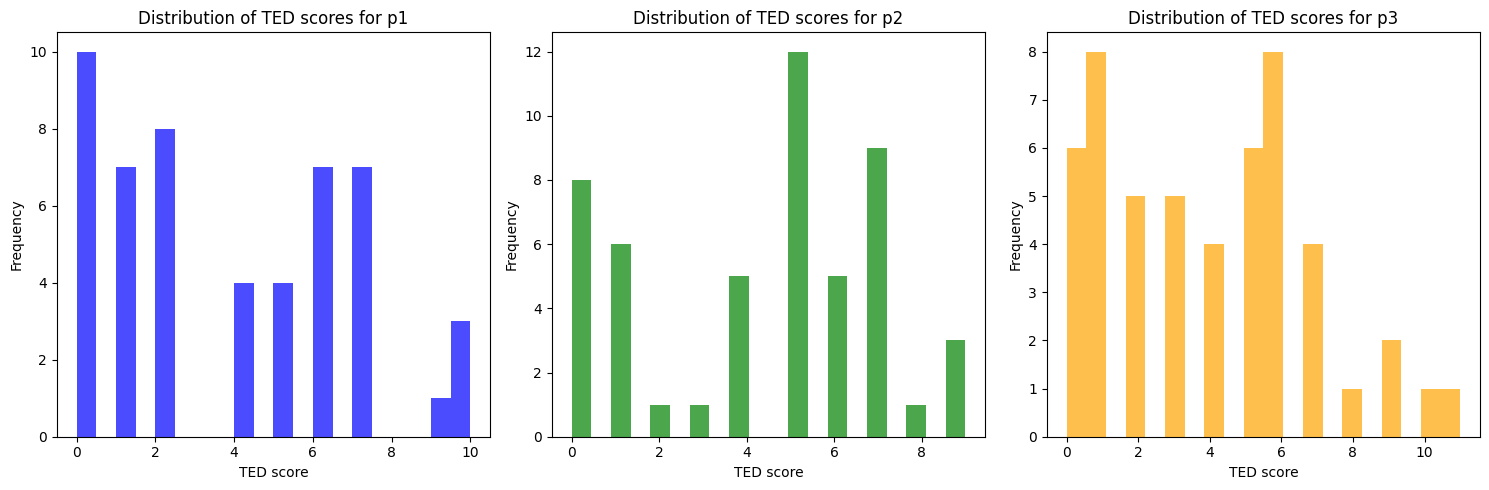

In [49]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of TED scores for p1
axs[0].hist(df['p1_ted'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Distribution of TED scores for p1')
axs[0].set_xlabel('TED score')
axs[0].set_ylabel('Frequency')

# Plot the distribution of TED scores for p2
axs[1].hist(df['p2_ted'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Distribution of TED scores for p2')
axs[1].set_xlabel('TED score')
axs[1].set_ylabel('Frequency')

# Plot the distribution of TED scores for p3
axs[2].hist(df['p3_ted'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Distribution of TED scores for p3')
axs[2].set_xlabel('TED score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_random_TED_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

### Compute Bertscore

In [41]:
from bert_score import score
from transformers import logging

logging.set_verbosity_error()#suppressing the display of warning messages.

def calculate_bert_scores(df,templates = ['p1', 'p2', 'p3']):
    """
    Calculate BERTScores for each pair of 'input_utterance' and paraphrases'pX' columns,
    and store the scores in the new columns 'pX_bertscore'.

    :args
        df(pd.DataFrame): The DataFrame containing the 'input_utterance' and 'pX_template' columns.
    """
    
    for template in tqdm(templates):
        col_bertscore = f'{template}_bertscore'
        _, _, bert_scores = score(list(df['INPUT:input_utterance']), list(df[template]), lang="en")
        df[col_bertscore] = bert_scores

In [42]:
# paraphrases_templates = utlty.get_template_for_bertscore(num_parahrases)
paraphrases_templates = ['p1', 'p2', 'p3']
calculate_bert_scores(df,paraphrases_templates)
df.head()[['INPUT:input_utterance',"p1", "p1_bertscore","p2", "p2_bertscore","p3", "p3_bertscore"]]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:40<00:00, 13.39s/it]


,INPUT:input_utterance,p1,p1_bertscore,p2,p2_bertscore,p3,p3_bertscore
0,Terminate i-a541 now,Eliminate i-a541 now,0.967082,i-a541 must be terminated immediately.,0.865731,Cancel i-a541 now,0.964517
1,Search for cooking videos,I need cooking videos,0.923296,explore cooking videos,0.957693,find Cooking VIDEOS,0.855351
2,Find most popular photos tagged #LOVE,Find popular photos tagged #LOVE,0.983964,which photos with a hashtag #LOVE are the most...,0.935143,Display most popular images with the tag #LOVE,0.976946
3,Search for a few nice photos matching Opera Ho...,Find a few nice photos related to Opera House ...,0.969219,Search for some nice photographs matching Oper...,0.989363,Can you search few nice photos matching Opera ...,0.954456
4,Are the burglar alarms in the office malfuncti...,Are the burglar alarms in the office spoiled?,0.964061,Do the office alarms for burglars function?,0.922950,Are the burglar alarms malfunctioning in the o...,0.985348


In [43]:
# Checkpoint save the df
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/Jorge-bootstrap-random-with-bertscore-{current_time}.csv")
df.to_csv(path_to_plot_file, index=False)

## Sanity Check
We perform two checks on the generated paraphrases to ensure they are not duplicates or semantically unrelated. The bertscore metric is used for this purpose.
1. If the bertscore is greater than 0.98, the current paraphrase is identified as a duplicate.
2. If the bertscore is less than 0.5, the current paraphrase is considered not semantically related to the input_utterance.

In [44]:
def add_duplicate_semantics_columns(df):
    """
    Add 'pX_duplicate' and 'pX_semantics' columns to the DataFrame based on the 'pX_bertscore' columns.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the columns 'p1_bertscore', 'p2_bertscore', 'p3_bertscore'
                           where X is a number from 1 to 3.

    Returns:
        pd.DataFrame: The DataFrame with additional 'pX_duplicate' and 'pX_semantics' columns.

    Example:
        df = pd.DataFrame({
            'p1_bertscore': [0.95, 0.99, 0.85],
            'p2_bertscore': [0.75, 0.92, 0.98],
            'p3_bertscore': [0.80, 0.45, 0.88]
        })

        df_with_columns = add_duplicate_semantics_columns(df)
        print(df_with_columns)
    """
    for i in tqdm(range(1, 4)):
        # Add 'pX_duplicate' column with True if pX_bertscore > 0.98, otherwise False
        column_duplicate = f'p{i}_duplicate'
        df[column_duplicate] = df[f'p{i}_bertscore'] > 0.98

        # Add 'pX_semantics' column with True if pX_bertscore >= 0.5, otherwise False
        column_semantics = f'p{i}_semantics'
        df[column_semantics] = df[f'p{i}_bertscore'] >= 0.5

In [45]:
add_duplicate_semantics_columns(df)
df.head()[["INPUT:row_pk","INPUT:input_utterance","p1", "p1_semantics","p1_duplicate","p2", "p1_semantics","p2_duplicate","p3", "p1_semantics","p3_duplicate"]]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 396.82it/s]


,INPUT:row_pk,INPUT:input_utterance,p1,p1_semantics,p1_duplicate,p2,p1_semantics,p2_duplicate,p3,p1_semantics,p3_duplicate
0,1,Terminate i-a541 now,Eliminate i-a541 now,True,False,i-a541 must be terminated immediately.,True,False,Cancel i-a541 now,True,False
1,2,Search for cooking videos,I need cooking videos,True,False,explore cooking videos,True,False,find Cooking VIDEOS,True,False
2,3,Find most popular photos tagged #LOVE,Find popular photos tagged #LOVE,True,True,which photos with a hashtag #LOVE are the most...,True,False,Display most popular images with the tag #LOVE,True,False
3,4,Search for a few nice photos matching Opera Ho...,Find a few nice photos related to Opera House ...,True,False,Search for some nice photographs matching Oper...,True,True,Can you search few nice photos matching Opera ...,True,False
4,5,Are the burglar alarms in the office malfuncti...,Are the burglar alarms in the office spoiled?,True,False,Do the office alarms for burglars function?,True,False,Are the burglar alarms malfunctioning in the o...,True,True


### Statistics
This script contains a function called print_duplicates_and_non_semantic_related, which helps in identifying rows that are duplicates or not semantically related in a given DataFrame. The function takes a pandas DataFrame as input, where the DataFrame should have columns named 'pX_duplicate' and 'pX_semantics', where 'X' is the paraphrase number (e.g., p1, p2, p3).

In [46]:
def print_duplicates_and_non_semantic_related(df):
    """
    Print rows that are duplicates or not semantically related based on the 'pX_duplicate' and 'pX_semantics' columns.

    :param df: pandas DataFrame containing the 'pX_duplicate' and 'pX_semantics' columns.
    """

    # Print rows that are duplicates
    print("Rows that are duplicates:")
    print(df[df['p1_duplicate'] | df['p2_duplicate'] | df['p3_duplicate']])

    # Print rows that are not semantically related
    print("\nRows that are not semantically related:")
    print(df[~(df['p1_semantics'] | df['p2_semantics'] | df['p3_semantics'])])

In [47]:
print_duplicates_and_non_semantic_related(df)

Rows that are duplicates:
   INPUT:row_pk                    OUTPUT:worker_uuid          INPUT:intent  \
2             3  b0f76f06-5028-50b6-116f-7e034c6b28c4             SearchWeb   
3             4  4ea7576a-23f4-0a1b-f344-856a32e087f2             SearchWeb   
4             5  482a12f4-2adf-a9e7-2527-a856a094185f           CheckDevice   
7             8  95a90c53-6858-e811-3a18-d8102266ecb6             FindHotel   
9            10  cc32a529-131d-97d1-ca87-2c35b45fe3c2          FindArticles   
13           14  34de43fa-5e10-363f-d965-5c2d3b232f22      NavigatePlaylist   
19           20  67675b91-7d20-9168-c2dd-51e372ad8c2a              BookTaxi   
23           24  140a5431-8a96-a4cd-7352-ee7c399b8f04        BookRestaurant   
26           27  b1e912d5-8244-d8fe-5a91-f7739b1e91cf         AddToPlaylist   
29           30  9ad07cac-a213-6030-b38b-f7212181293d              RateBook   
31           32  e9ff858e-5877-1995-d121-53dfbd266cf1              RateBook   
37           38  e8bec448-

### Plot
This code will create a figure with three subplots, each showing the distribution of **TED** scores for p1, p2, and p3. The histogram bins are set to 20, but you can adjust it based on the range and spread of your **TED** scores. The colors and alpha values can be adjusted to your preference as well.

#### Plot over TED scores

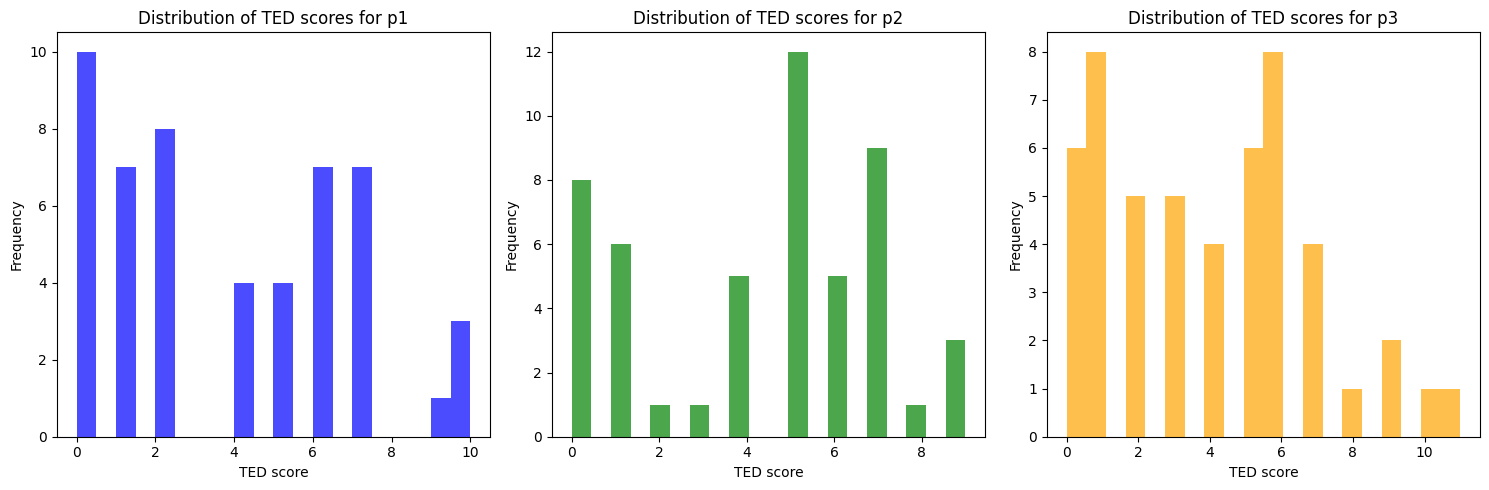

In [50]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of TED scores for p1
axs[0].hist(df['p1_ted'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Distribution of TED scores for p1')
axs[0].set_xlabel('TED score')
axs[0].set_ylabel('Frequency')

# Plot the distribution of TED scores for p2
axs[1].hist(df['p2_ted'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Distribution of TED scores for p2')
axs[1].set_xlabel('TED score')
axs[1].set_ylabel('Frequency')

# Plot the distribution of TED scores for p3
axs[2].hist(df['p3_ted'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Distribution of TED scores for p3')
axs[2].set_xlabel('TED score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_TED_random_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

#### Plot over BERT scores

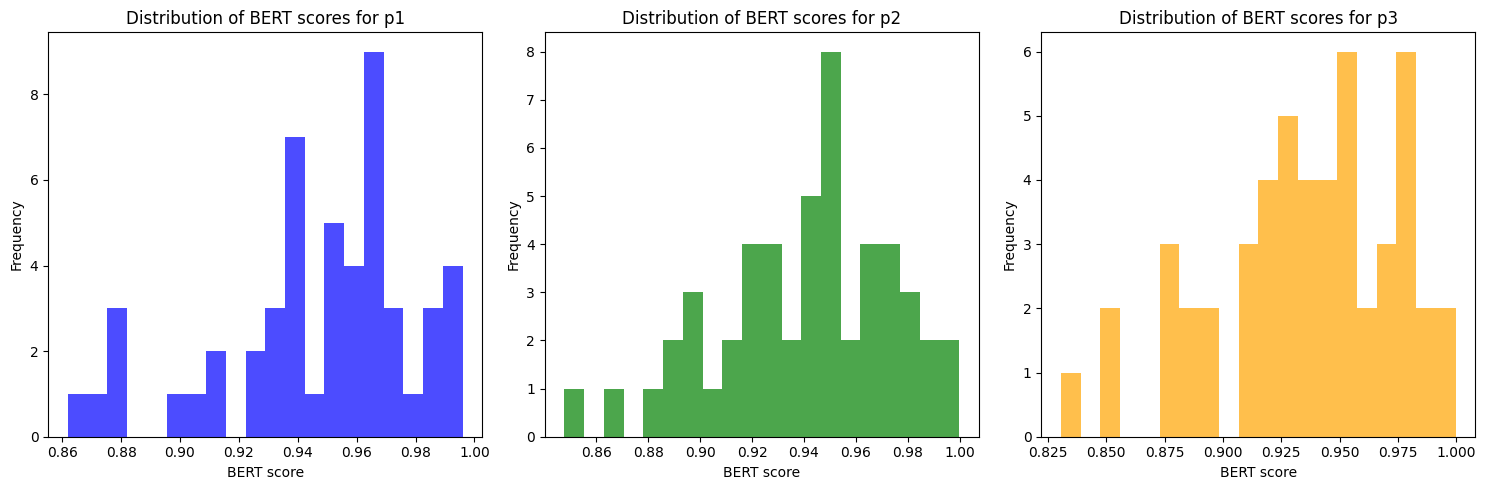

In [51]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the distribution of BERT scores for p1
axs[0].hist(df['p1_bertscore'], bins=20, color='blue', alpha=0.7)
axs[0].set_title('Distribution of BERT scores for p1')
axs[0].set_xlabel('BERT score')
axs[0].set_ylabel('Frequency')

# Plot the distribution of BERT scores for p2
axs[1].hist(df['p2_bertscore'], bins=20, color='green', alpha=0.7)
axs[1].set_title('Distribution of BERT scores for p2')
axs[1].set_xlabel('BERT score')
axs[1].set_ylabel('Frequency')

# Plot the distribution of BERT scores for p3
axs[2].hist(df['p3_bertscore'], bins=20, color='orange', alpha=0.7)
axs[2].set_title('Distribution of BERT scores for p3')
axs[2].set_xlabel('BERT score')
axs[2].set_ylabel('Frequency')

plt.tight_layout()

# Save the plot to a file (e.g., a PNG file)
path_to_plot_file = f"{os.getcwd()}/plots/Jorge_bootstrap_random_BERTscores_distribution.pdf"#test_data
plt.savefig(path_to_plot_file)

plt.show()

In [68]:
# median judgment time for all workers and then per "paraphrase_0_notes"
p1_bertscore_median = df["p1_bertscore"].median()
p1_bertscore_mean = df["p1_bertscore"].mean()
print(f"p1_bertscore_mean: Median: {p1_bertscore_median:.4f}. Mean: {p1_bertscore_mean:.4f}.\n")

p1_bertscore_mean: Median: 0.9515. Mean: 0.9463.



In [52]:
# Save the plot to a file
path_to_plot_file = f"{os.getcwd()}/output/Jorge-bootstrap-random-round-results-processed.csv"#test_data
df.to_csv(path_to_plot_file, index=False)

### Plot syntaxtic distribution
Let's visualize the distribution of parse templates for the paraphrases of the first input utterance in the dataset.

In [26]:
df.columns

Index(['INPUT:row_pk', 'OUTPUT:worker_uuid', 'INPUT:intent',
       'INPUT:input_utterance', 'paraphrase_value', 'rand_baseline', 'rand_cw',
       'distance_to_mean', 'distance_to_seed', 'INPUT:parameters',
       'is_correct', 'tag', 'C2.is_correct_m', 'C2.tag_m', 'C1.C2.agreement',
       'paraphrase_pattern', 'INPUT:prompt_context', 'paraphrase_key',
       'INPUT:source', 'INPUT:input_pattern', 'INPUT:masked_ngrams',
       'INPUT:input_utterance_words', 'INPUT:input_utterance_lemmatized_words',
       'OUTPUT:trace', 'OUTPUT:screen_width', 'OUTPUT:screen_height',
       'OUTPUT:page_started_at', 'OUTPUT:provided_ngrams',
       'OUTPUT:page_started_at_string', 'ASSIGNMENT:link',
       'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id',
       'ASSIGNMENT:task_suite_id', 'ASSIGNMENT:worker_id', 'ASSIGNMENT:status',
       'ASSIGNMENT:started', 'ASSIGNMENT:submitted', 'ASSIGNMENT:accepted',
       'ASSIGNMENT:rejected', 'ASSIGNMENT:skipped', 'ASSIGNMENT:expired',
       'ASSIGNMENT:

### Select correct paraphrases only
To plot paraphrases syntax template distribution, we first need to select the correct paraphrases, which are those that are both semantically related to the input utterance and not duplicates of the input utterance. These correct paraphrases will be used to generate the distribution plot of the syntax templates.

#### Step 1 - add p1_correct, p2_correct and p3_correct columns

In [53]:
# Add 'pX_correct' column with True if both pX_bertscore >= 0.5 and pX_bertscore < 0.98, otherwise False
for i in range(1, 4):
    column_correct = f'p{i}_correct'
    df[column_correct] = (df[f'p{i}_bertscore'] >= 0.5) & (df[f'p{i}_bertscore'] < 0.98)

df[df['p1_correct'] == False][['INPUT:input_utterance','p1_correct','p2_correct','p3_correct','p1_bertscore', 'p2_bertscore', 'p3_bertscore']]

,INPUT:input_utterance,p1_correct,p2_correct,p3_correct,p1_bertscore,p2_bertscore,p3_bertscore
2,Find most popular photos tagged #LOVE,False,True,True,0.983964,0.935143,0.976946
7,Are there any cheap hotels for 7-day stay some...,False,True,True,0.985013,0.965780,0.946955
19,Request a taxi from the airport to home,False,False,False,0.989413,0.999826,0.999784
29,"I would give With Lee in Virginia, A Story of ...",False,True,True,0.989758,0.950874,0.922465
37,I would like to watch The Wedding Ring at the ...,False,True,True,0.994724,0.977020,0.953346
39,find Join the Dots: B-sides and Rarities,False,False,False,0.981496,0.981137,0.981496
41,please give me the cheapest flight from denver...,False,True,True,0.983053,0.969868,0.975247
46,can i get a rental car in dallas,False,True,True,0.995995,0.959133,0.966803


In [54]:
# Save the plot to a file
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"checkpoints/create-bootstrap-random-with-correct-{current_time}.csv")
df.to_csv(path_to_plot_file, index=False)

#### Extract Syntax Templates of Incorrect Paraphrases - Just for statistics.
In this step, we will extract the syntax templates of paraphrases that are deemed incorrect. For each row in the DataFrame, we will look at the corresponding 'pX_correct' column (where X is 1, 2, or 3). If the value in the 'pX_correct' column is False, it indicates that the paraphrase is not semantically related to the input_utterance or is a duplicate of it.

We will then extract the respective 'pX_template' column for all the incorrect paraphrases. For instance, if 'p1_correct' is False, we will take the 'p1_template' value, if 'p2_correct' is False, we will take the 'p2_template' value, and if 'p3_correct' is False, we will take the 'p3_template' value. This process ensures that we focus on the syntax templates of paraphrases that need further investigation or improvement.

In [55]:
# Extract the syntax templates of incorrect p1 paraphrases
incorrect_p1_template = df.loc[~df['p1_correct'], 'p1_template']

# Extract the syntax templates of incorrect p2 paraphrases
incorrect_p2_template = df.loc[~df['p2_correct'], 'p2_template']

# Extract the syntax templates of incorrect p3 paraphrases
incorrect_p3_template = df.loc[~df['p3_correct'], 'p3_template']

# Concatenate them into one new series called combined_series
combined_series = pd.concat([incorrect_p1_template, incorrect_p2_template, incorrect_p3_template], ignore_index=True)

print(f"Number of incorrect paraphrases: {combined_series.shape[0]}")
combined_series

Number of incorrect paraphrases: 21


0                             ( S ( VP ( VB ) ( S ) ) )
1     ( SQ ( VBP ) ( NP ( EX ) ) ( NP ( NP ) ( PP ) ) )
2        ( S ( VP ( VB ) ( NP ) ( PP ) ( PP ) ) ( . ) )
3             ( S ( NP ( PRP ) ) ( VP ( MD ) ( VP ) ) )
4             ( S ( NP ( PRP ) ) ( VP ( MD ) ( VP ) ) )
5     ( S ( S ( VP ) ) ( : ) ( NP ( NNS ) ( CC ) ( N...
6                     ( S ( VP ( VB ) ( NP ) ( NP ) ) )
7       ( SBAR ( WHADVP ( WRB ) ) ( S ( NP ) ( VP ) ) )
8             ( NP ( NP ( VB ) ) ( PP ( IN ) ( NP ) ) )
9                            ( S ( VP ( VB ) ( PP ) ) )
10             ( S ( VP ( VB ) ( NP ) ( PP ) ( PP ) ) )
11            ( S ( NP ( PRP ) ) ( VP ( MD ) ( VP ) ) )
12    ( NP ( NP ( NP ) ( PP ) ) ( : ) ( NP ( NNS ) (...
13    ( SBARQ ( WHNP ( WDT ) ( NNS ) ) ( VP ( VBP ) ...
14    ( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( VP...
15                     ( S ( VP ( VB ) ( NP ) ) ( . ) )
16             ( S ( VP ( VB ) ( NP ) ( PP ) ( PP ) ) )
17    ( S ( X ( UH ) ) ( VP ( VB ) ( NP ) ( PP )

In [56]:
# Save the syntax of incorrect paraphrases
current_time = time.strftime("%Y%m%d-%H%M%S")
path_to_plot_file = os.path.join(os.getcwd(), f"input/create-bootstrap-random-incorrect-paraphrases-templates-{current_time}.csv")
df.to_csv(path_to_plot_file, index=False)

#### Step 2 - Extract Syntax Templates of correct Paraphrases
In this step, we will extract the syntax templates of paraphrases that are deemed correct. For each row in the DataFrame, we will look at the corresponding 'pX_correct' column (where X is 1, 2, or 3). If the value in the 'pX_correct' column is True, it indicates that the paraphrase is semantically related to the input_utterance and not a duplicate of it.

We will then extract the respective 'pX_template' column for all the correct paraphrases. For instance, if 'p1_correct' is True, we will take the 'p1_template' value, if 'p2_correct' is True, we will take the 'p2_template' value, and if 'p3_correct' is True, we will take the 'p3_template' value. This process ensures that we focus on the syntax templates of paraphrases that are considered acceptable and reliable.

In [57]:
# Extract the syntax templates of incorrect p1 paraphrases
correct_p1_template = df.loc[df['p1_correct'], 'p1_template']

# Extract the syntax templates of incorrect p2 paraphrases
correct_p2_template = df.loc[df['p2_correct'], 'p2_template']

# Extract the syntax templates of incorrect p3 paraphrases
correct_p3_template = df.loc[df['p3_correct'], 'p3_template']

# Concatenate them into one new series called combined_series
combined_series = pd.concat([correct_p1_template, correct_p2_template, correct_p3_template], ignore_index=True)
combined_series

0                    ( S ( VP ( VB ) ( NP ) ( ADVP ) ) )
1             ( S ( NP ( PRP ) ) ( VP ( VBP ) ( NP ) ) )
2                             ( S ( VP ( VB ) ( NP ) ) )
3      ( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...
4      ( SQ ( VBZ ) ( NP ( DT ) ( NN ) ) ( VP ( NN ) ...
                             ...                        
127             ( S ( VP ( VB ) ( NP ) ( NP ) ( PP ) ) )
128    ( SBARQ ( WHADVP ( WRB ) ) ( SQ ( MD ) ( NP ) ...
129                   ( S ( VP ( VB ) ( PRT ) ( NP ) ) )
130      ( SBARQ ( WHNP ( WP ) ) ( VP ( VBZ ) ( NP ) ) )
131                ( SBAR ( WHNP ( WP ) ) ( S ( VP ) ) )
Length: 132, dtype: object

### Plot the syntactic templates distribution

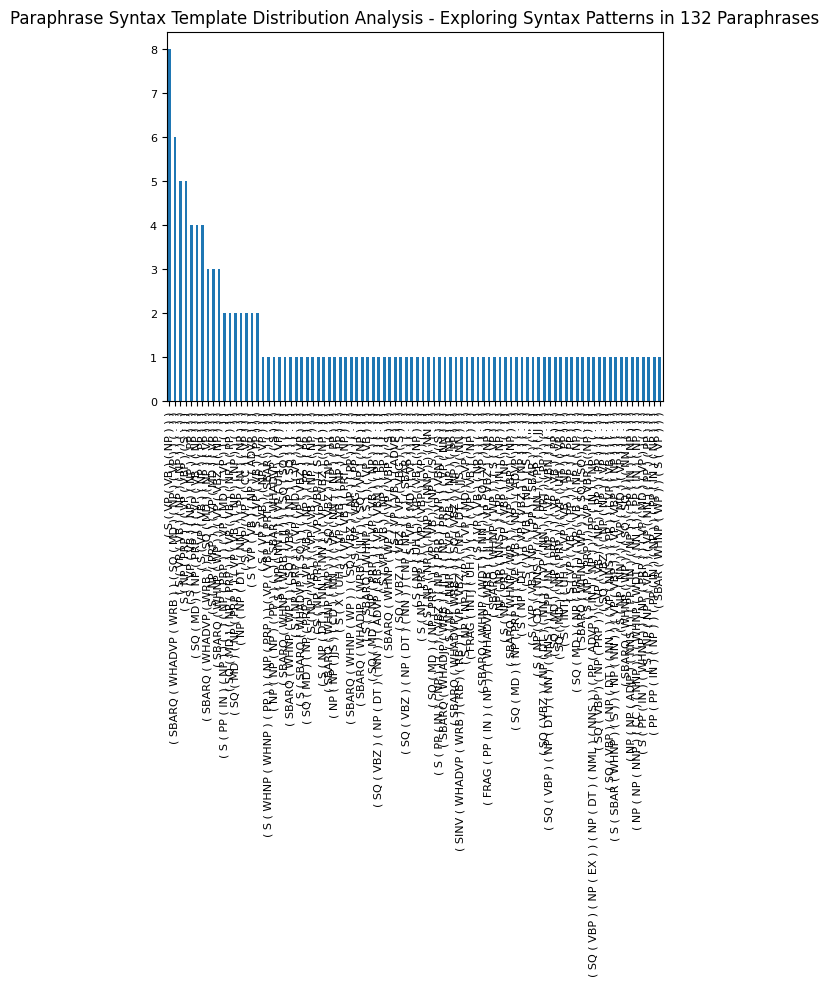

In [58]:
number_of_rows = combined_series.shape[0]

# Assuming you have a series called 'paraphrases_templates_series'
ax = combined_series.value_counts().plot(
    kind="bar",
    title=f"Paraphrase Syntax Template Distribution Analysis - Exploring Syntax Patterns in {number_of_rows} Paraphrases",
    fontsize=8,
)

# Save the plot to a file (e.g., a PDF file)
path_to_plot_file = f"{os.getcwd()}/plots/bootstrap_random_correct_paraphrases_syntax_template_distribution.pdf"  # Test data
plt.savefig(path_to_plot_file, bbox_inches='tight')

# Optionally, display the plot on the screen
plt.show()

### Compute metrics
To analyze the quality of paraphrases, we will calculate three metrics: DIv, TTR, and mean PINC scores.
1. `Step 1 - Data Preparation`:

   First, we will extract all correct p1, p2, and p3 paraphrases and merge the values from these three columns into a single column called "paraphrase_value." This will result in a new DataFrame with two columns: 'INPUT:input_utterance' and 'paraphrase_value'.
2. `Metric Calculation`:

   Next, we will compute the DIv, TTR, and mean PINC scores for the paraphrases in the "paraphrase_value" column. These metrics will provide valuable insights into the diversity, lexical richness, and fluency of the generated paraphrases.

#### Step 1 - Data preparation

In [59]:
# Extract the syntax templates of incorrect p1 paraphrases
correct_p1_template = df.loc[df['p1_correct'], ['INPUT:input_utterance','p1','p1_template']]
correct_p1_template.rename(columns={'p1': 'paraphrase_value'}, inplace=True)# rename p1 to paraphrase_value
correct_p1_template.rename(columns={'p1_template': 'paraphrase_template'}, inplace=True)# rename p1_template to paraphrase_template


# Extract the syntax templates of incorrect p2 paraphrases
correct_p2_template = df.loc[df['p2_correct'], ['INPUT:input_utterance','p2','p2_template']]
correct_p2_template.rename(columns={'p2': 'paraphrase_value'}, inplace=True)
correct_p2_template.rename(columns={'p2_template': 'paraphrase_template'}, inplace=True)


# Extract the syntax templates of incorrect p3 paraphrases
correct_p3_template = df.loc[df['p3_correct'], ['INPUT:input_utterance','p3','p3_template']]
correct_p3_template.rename(columns={'p3': 'paraphrase_value'}, inplace=True)
correct_p3_template.rename(columns={'p3_template': 'paraphrase_template'}, inplace=True)

# Concatenate them into one new series called combined_series
combined_series = pd.concat([correct_p1_template, correct_p2_template, correct_p3_template], ignore_index=True)
combined_series

,INPUT:input_utterance,paraphrase_value,paraphrase_template
0,Terminate i-a541 now,Eliminate i-a541 now,( S ( VP ( VB ) ( NP ) ( ADVP ) ) )
1,Search for cooking videos,I need cooking videos,( S ( NP ( PRP ) ) ( VP ( VBP ) ( NP ) ) )
2,Search for a few nice photos matching Opera Ho...,Find a few nice photos related to Opera House ...,( S ( VP ( VB ) ( NP ) ) )
3,Are the burglar alarms in the office malfuncti...,Are the burglar alarms in the office spoiled?,( SQ ( VBP ) ( NP ( DT ) ( NN ) ( NNS ) ) ( PP...
4,Is the TV in the house off ?,Does the TV swift off in the house?,( SQ ( VBZ ) ( NP ( DT ) ( NN ) ) ( VP ( NN ) ...
...,...,...,...
127,what is the ground transportation from oakland...,tell me the vehicles from oakland to san franc...,( S ( VP ( VB ) ( NP ) ( NP ) ( PP ) ) )
128,can i get a rental car in dallas,How can i get a rental car in dallas,( SBARQ ( WHADVP ( WRB ) ) ( SQ ( MD ) ( NP ) ...
129,show me the airlines between boston and denver,Point out the airlines between boston and denver,( S ( VP ( VB ) ( PRT ) ( NP ) ) )
130,what does ls stand for,What's the meaning of ls,( SBARQ ( WHNP ( WP ) ) ( VP ( VBZ ) ( NP ) ) )


#### Step 2 - Compute metrics

In [60]:
input_utterance = combined_series["INPUT:input_utterance"][0]

def compute_metrics(df, input_utterance):
    df_s = df[df["INPUT:input_utterance"] == input_utterance]
    paraphrases = df_s["paraphrase_value"].values
    ttr_metric = metrics.compute_ttr(input_utterance, paraphrases)
    pincs = [metrics.compute_pinc(input_utterance, p) for p in paraphrases]
    mean_pinc = sum(pincs) / len(pincs)
    div = metrics.compute_div({input_utterance: paraphrases})
    return ttr_metric["ttr"], mean_pinc, div

ttrs = []
mean_pincs = []
divs = []
# df_correct = df[df.is_correct == 1]

for iu in combined_series["INPUT:input_utterance"]:
    ttr, mean_pinc, div = compute_metrics(combined_series,iu)
    ttrs.append(ttr)
    mean_pincs.append(mean_pinc)
    divs.append(div)

ttrs = np.array(ttrs)
mean_pincs = np.array(mean_pincs)
divs = np.array(divs)
print(f"\nMean TTR: {ttrs.mean():.4f} \nMean PINC: {mean_pincs.mean():.4f} \nDIV: {divs.mean():.4f}")


Mean TTR: 0.4642 
Mean PINC: 0.2823 
DIV: 0.6914


# Pattern Distribution Plot
Analyzing Patterns in Correct Paraphrases for 50 Seed Utterances. The plot showcases the frequency distribution of paraphrase patterns, specifically focusing on the correct paraphrases. After selecting the correct paraphrases, 50 Seed Utterances remain for analysis.

In [64]:
def plot_pattern_distribution(df, width=16, height=10, min_ncols=8, iu_column="INPUT:input_utterance"):
    ncols = min(min_ncols, df[iu_column].value_counts().shape[0])
    nrows = math.ceil(df[iu_column].value_counts().shape[0] / ncols)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_figwidth(width)
    fig.set_figheight(height)
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
    
    row = 0
    col = 0

    # Define a color palette for the patterns
    pattern_colors = sns.color_palette("Set1", n_colors=3)
    
    for _, input_utterance in enumerate(df[iu_column].value_counts().index.values):
        df_data = df[df[iu_column] == input_utterance]
        ax = axes[row][col] if nrows > 1 else axes[col]
        g = sns.countplot(
            x="paraphrase_template",
            data=df_data,
            order=df_data.paraphrase_template.value_counts().sort_values().index,
            ax=ax,
            palette=pattern_colors
        )
        g.set(xlabel="patterns")
        g.set(xticklabels=[])
        col += 1
        
        if col == ncols:
          col = 0
          row += 1

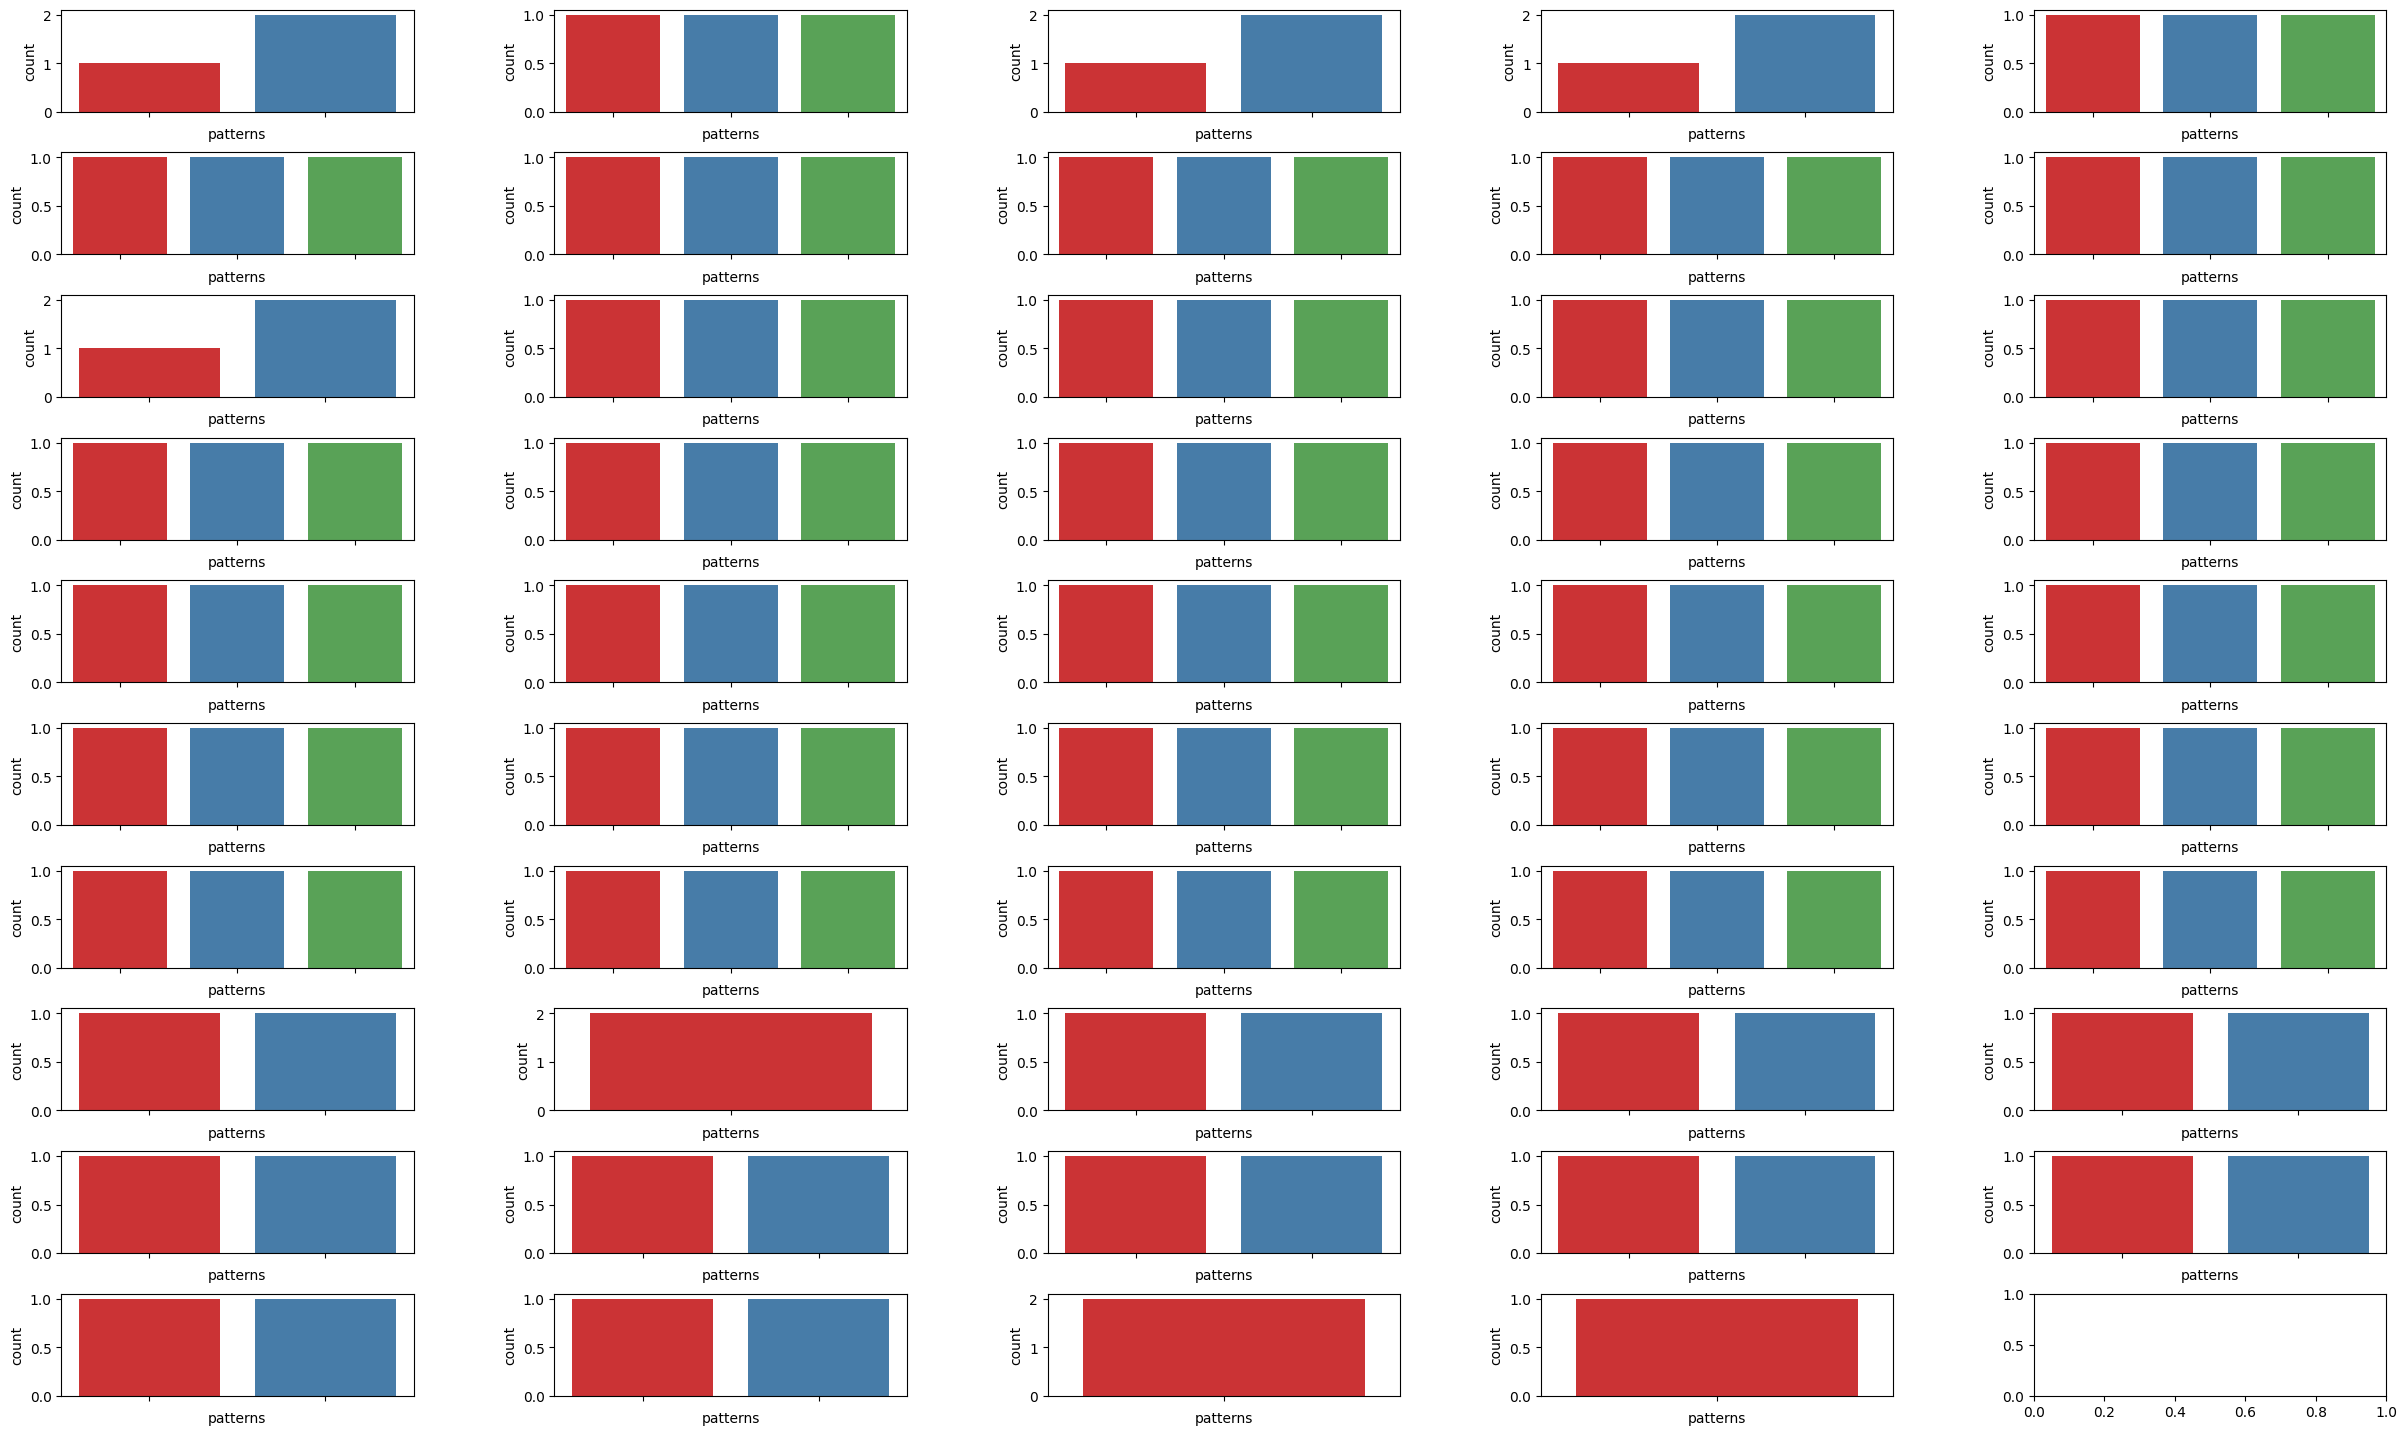

In [65]:
plot_pattern_distribution(combined_series, width=30, height=18, min_ncols=5)

In [66]:
combined_series.paraphrase_template.unique().shape

(90,)

In [70]:
# median judgment time for all workers and then per "paraphrase_0_notes"
p1_ted_median = df["p1_ted"].median()
p1_ted_mean = df["p1_ted"].mean()
print(f"p1_ted: Median: {p1_ted_median:.4f}. Mean: {p1_ted_mean:.4f}.\n")

# median judgment time for all workers and then per "paraphrase_0_notes"
p2_ted_median = df["p2_ted"].median()
p2_ted_mean = df["p2_ted"].mean()
print(f"p2_ted: Median: {p2_ted_median:.4f}. Mean: {p2_ted_mean:.4f}.\n")

# median judgment time for all workers and then per "paraphrase_0_notes"
p3_ted_median = df["p3_ted"].median()
p3_ted_mean = df["p3_ted"].mean()
print(f"p3_ted: Median: {p3_ted_median:.4f}. Mean: {p3_ted_mean:.4f}.\n")

p1_ted: Median: 4.0000. Mean: 3.7059.

p2_ted: Median: 5.0000. Mean: 4.2941.

p3_ted: Median: 4.0000. Mean: 3.9608.

